<a href="https://colab.research.google.com/github/ChangGeunOh/PetDog/blob/main/%5B%ED%95%B4%EC%84%A4%EC%9A%A9%5D_%EB%B0%98%EB%A0%A4%EA%B2%AC_%ED%8A%B9%EC%84%B1%EC%A0%95%EB%B3%B4%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 개요**

## **가. 패키지 설치 및 라이브러리 호출**

In [ ]:
import warnings
# 불필요한 경고 출력을 방지합니다.
warnings.filterwarnings('ignore')
import subprocess
import sys
import pandas as pd
import numpy as np
import pickle
import hashlib

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("folium")
install("seaborn")
install("xgboost")

## **나. 강의 목차**

1. 데이터 수집
2. 데이터 전처리
3. 데이터 시각화
4. 모델링


In [ ]:
# aidu 사용을 위한..
# SACP AI 포탈과 연계를 위한 기본 객체 생성
from aicentro.session import Session
sacp_session = Session(verify=False)
from aicentro.framework.keras import Keras as SacpFrm
sacp_framework = SacpFrm(session=sacp_session)

# **1. 데이터 수집**


## **가. JSON File CSV 변환**

In [ ]:
# 데이터 수집을 위한 Library
import json
from os import makedirs
from os.path import exists
from pathlib import Path

# JSON 파일을 csv 파일로 변환
def json_to_csv():
    folder_path = "./pet_dog"
    save_file_path = "./dog_data.csv"

    folder = Path(folder_path)
    save_folder = "/".join(save_file_path.split("/")[:-1])

    id_keys = ['group', 'breed', 'class', 'age', 'sex']
    physical_keys = ['weight', 'shoulder-height', 'neck-size', 'back-length', 'chest-size', 'BCS']
    breeding_keys = ['exercise', 'environment', 'defecation', 'food-count', 'food-amount', 'snack-amount', 'food-kind']

    if not exists(save_folder):
        makedirs(save_folder)

    with open(save_file_path, "w") as save_file:
        if folder.exists() and folder.is_dir():
            save_file.write(','.join(id_keys + physical_keys + breeding_keys) + "\n")
            for file in folder.glob("*.json"):
                with open(file, "r", encoding="utf-8") as data_file:
                    dog_cat_data = json.load(data_file)
                    line = write_line(dog_cat_data['metadata'], id_keys, physical_keys, breeding_keys)
                    save_file.write(line + "\n")
        else:
            print("폴더가 존재하지 않거나 올바른 폴더가 아닙니다.")

def write_line(metadata, id_keys, physical_keys, breeding_keys):
    id_values = ','.join(str(metadata['id'][key]) for key in id_keys)
    physical_values = ','.join(str(metadata['physical'][key]) for key in physical_keys)
    breeding_values = ','.join(str(metadata['breeding'][key]) for key in breeding_keys)

    return f"{id_values},{physical_values},{breeding_values}"


In [ ]:
# JSON 데이터 변환시 주석 제거

# json_to_csv()

In [ ]:
# 패키지 설치
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score

## **나. 데이터 불러오기**

In [ ]:
# 실습 코드 : 데이터 읽기 (padas 이용))

dog_data = pd.read_csv('dog_data.csv')

In [ ]:
# 실습 코드 : 상위 5개 데이터 확인

dog_data.head()

,group,breed,class,age,sex,weight,shoulder-height,neck-size,back-length,chest-size,BCS,exercise,environment,defecation,food-count,food-amount,snack-amount,food-kind
0,SS,POO,SH,3.0,IF,1.0,23.0,17.0,29.0,29.0,5,3,1,1,1,0.5,0.0,1
1,SS,POO,SH,4.0,IF,3.0,28.0,19.0,35.0,33.0,5,3,1,1,2,1.0,0.0,1
2,SL,BIC,LH,2.0,IF,2.0,20.0,20.0,27.0,31.0,5,3,2,1,4,1.0,0.0,1
3,SL,POM,LH,2.0,IM,3.0,22.5,21.0,28.0,32.0,4,3,1,1,2,1.0,0.0,1
4,LL,SHE,LH,1.0,IM,12.0,45.0,32.0,44.0,53.0,5,3,1,1,1,1.0,0.0,1


In [ ]:
# 실습 코드 : 통계 데이터 요약 확인

dog_data.describe()

,age,weight,shoulder-height,neck-size,back-length,chest-size,BCS,exercise,environment,defecation,food-count,food-amount,snack-amount,food-kind
count,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000,68388.000000
mean,3.937292,4.783579,27.196333,23.154913,31.249899,36.616070,4.928730,2.575774,1.037039,1.007165,2.599842,1.179942,2.975510,1.037945
std,3.024603,5.557425,8.375594,6.424381,9.332927,10.413137,0.714872,0.619674,0.188858,0.084343,1.267602,0.811666,7.600335,0.191065
min,0.000000,0.300000,3.000000,0.000000,6.000000,9.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.200000,0.000000,1.000000
25%,2.000000,2.100000,22.000000,20.000000,25.000000,30.000000,5.000000,2.000000,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000
50%,3.000000,3.000000,25.000000,22.000000,29.000000,34.000000,5.000000,3.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000
75%,5.000000,5.000000,29.000000,25.000000,35.000000,40.000000,5.000000,3.000000,1.000000,1.000000,4.000000,1.500000,0.000000,1.000000
max,18.000000,53.000000,76.000000,73.000000,86.000000,101.000000,9.000000,3.000000,2.000000,2.000000,4.000000,15.000000,100.000000,2.000000


**Column 설명**
- breed : 품종
- age : 나이
- sex : 성별
- class : 장단모
- weight : 무게
- shoulder-height : 견갑부 높이
- neck-size : 목둘레
- back-length : 등허리 길이
- chest-size : 흉곽둘레
- BCS : 신체충실 지수
- excecise : 운동강도
- environment : 생활환경
- defecation : 배변사태
- food-count : 식이횟수
- foot-mount : 식사량
- snack-amount : 간식량
- food-kind : 식사종류

## **다. 데이터 도식화**

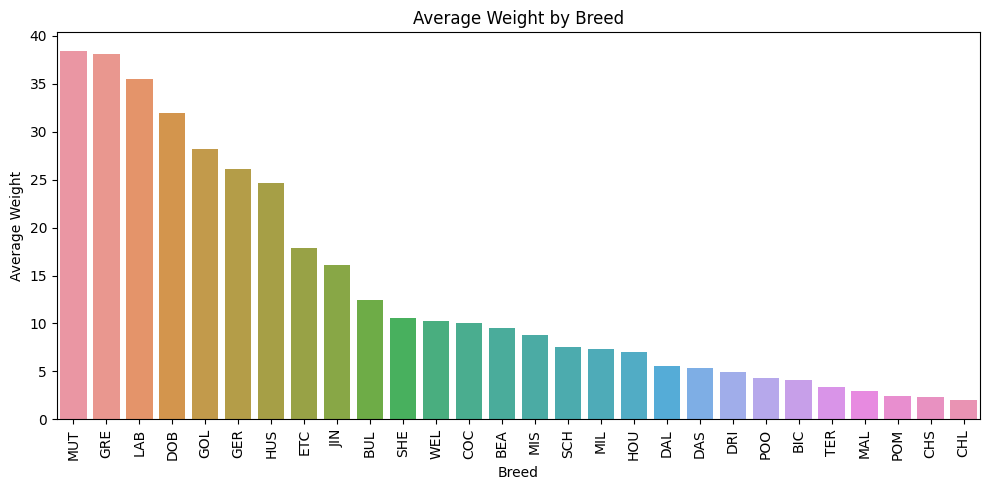

In [ ]:
# 실습 코드 : 품종별 평균 몸무게 바차트로 표현

import matplotlib.pyplot as plt
import seaborn as sns

# breed 별로 weight의 평균을 계산
avg_weight_by_breed = dog_data.groupby('breed')['weight'].mean().sort_values(ascending=False)

# 바 차트로 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_weight_by_breed.index, y=avg_weight_by_breed.values)

plt.title('Average Weight by Breed')
plt.xlabel('Breed')
plt.ylabel('Average Weight')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

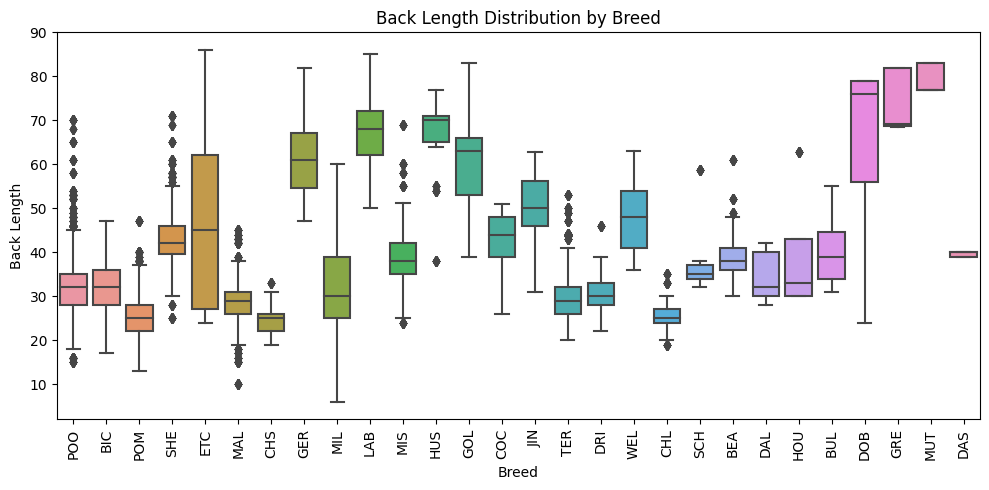

In [ ]:
# 실습 코드 : 품종별 등허리 길이 박스플롯 표현

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x='breed', y='back-length', data=dog_data)

plt.title('Back Length Distribution by Breed')
plt.xlabel('Breed')
plt.ylabel('Back Length')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# **2. 데이터 전처리**

In [ ]:
# 실습 코드 : 데이터 확인

dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68388 entries, 0 to 68387
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   group            68388 non-null  object 
 1   breed            68388 non-null  object 
 2   class            68388 non-null  object 
 3   age              68388 non-null  float64
 4   sex              68388 non-null  object 
 5   weight           68388 non-null  float64
 6   shoulder-height  68388 non-null  float64
 7   neck-size        68388 non-null  float64
 8   back-length      68388 non-null  float64
 9   chest-size       68388 non-null  float64
 10  BCS              68388 non-null  int64  
 11  exercise         68388 non-null  int64  
 12  environment      68388 non-null  int64  
 13  defecation       68388 non-null  int64  
 14  food-count       68388 non-null  int64  
 15  food-amount      68388 non-null  float64
 16  snack-amount     68388 non-null  float64
 17  food-kind   

## **가. 결측값 확인 및 제거**

In [ ]:
# 실습 코드 : 상관관계가 높은 Feature (class) 삭제 (group과 class)

dog_data.drop(['class'], inplace = True, axis = 1)

In [ ]:
# 결손 데이터 확인

dog_data.isnull().sum()

group              0
breed              0
age                0
sex                0
weight             0
shoulder-height    0
neck-size          0
back-length        0
chest-size         0
BCS                0
exercise           0
environment        0
defecation         0
food-count         0
food-amount        0
snack-amount       0
food-kind          0
dtype: int64

In [ ]:
# 실습 코드 : 결손 데이터 처리 (필요시)

dog_data.dropna(inplace = True)

In [ ]:
# 실습 코드 : 데이터 확인

dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68388 entries, 0 to 68387
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   group            68388 non-null  object 
 1   breed            68388 non-null  object 
 2   age              68388 non-null  float64
 3   sex              68388 non-null  object 
 4   weight           68388 non-null  float64
 5   shoulder-height  68388 non-null  float64
 6   neck-size        68388 non-null  float64
 7   back-length      68388 non-null  float64
 8   chest-size       68388 non-null  float64
 9   BCS              68388 non-null  int64  
 10  exercise         68388 non-null  int64  
 11  environment      68388 non-null  int64  
 12  defecation       68388 non-null  int64  
 13  food-count       68388 non-null  int64  
 14  food-amount      68388 non-null  float64
 15  snack-amount     68388 non-null  float64
 16  food-kind        68388 non-null  int64  
dtypes: float64(8

## **나. 데이터 Sampling (추출)**

In [ ]:
# 실습 코드 : Sampling 데이터 추출 (n = 3000, random_state = 42)

dog_data = dog_data.sample(n = 3000, random_state = 42)
dog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 25887 to 21632
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   group            3000 non-null   object 
 1   breed            3000 non-null   object 
 2   age              3000 non-null   float64
 3   sex              3000 non-null   object 
 4   weight           3000 non-null   float64
 5   shoulder-height  3000 non-null   float64
 6   neck-size        3000 non-null   float64
 7   back-length      3000 non-null   float64
 8   chest-size       3000 non-null   float64
 9   BCS              3000 non-null   int64  
 10  exercise         3000 non-null   int64  
 11  environment      3000 non-null   int64  
 12  defecation       3000 non-null   int64  
 13  food-count       3000 non-null   int64  
 14  food-amount      3000 non-null   float64
 15  snack-amount     3000 non-null   float64
 16  food-kind        3000 non-null   int64  
dtypes: float6

## **나. 타겟(목표)값 라벨링**

In [ ]:
# 실습 코드 : 타겟(목표)값 빈도 확인

dog_data['BCS'].value_counts()

5    2091
4     441
6     287
3     106
7      53
8      11
2       6
9       5
Name: BCS, dtype: int64

In [ ]:
# 실습 코드 : BCS 라벨링 (3 이하 : 저체중, 4~5 : 정상, 6 이상 : 과체중)

dog_data = dog_data.copy()

def categorize_bcs(bcs):
    if bcs <= 3:
        return '저체중'
    elif 4 <= bcs <=5:
        return '정상'
    else:
        return '과체중'

dog_data.loc[:, 'BCS'] = dog_data['BCS'].apply(categorize_bcs)

In [ ]:
# 실습 코드 : 라벨링된 타겟(목표)값 빈도 확인

dog_data['BCS'].value_counts()

정상     2532
과체중     356
저체중     112
Name: BCS, dtype: int64

In [ ]:
# 실습 코드 : 데이터 확인 (마지막 10개)

dog_data.tail(10)

,group,breed,age,sex,weight,shoulder-height,neck-size,back-length,chest-size,BCS,exercise,environment,defecation,food-count,food-amount,snack-amount,food-kind
17588,SL,MAL,2.0,IF,2.4,20.0,17.0,26.0,27.0,정상,3,1,1,1,1.0,0.0,1
17339,MS,POO,6.0,CM,8.0,25.0,25.0,35.0,49.0,과체중,1,1,1,2,1.0,0.0,1
56457,SS,POO,1.0,IF,1.8,22.0,19.0,24.0,28.0,정상,3,1,1,4,2.0,0.0,1
17444,SL,BIC,3.0,IM,2.0,20.0,15.0,27.0,29.0,정상,3,2,1,4,1.0,0.0,1
35286,SL,POM,5.0,IF,2.0,22.0,22.0,25.0,32.0,정상,2,1,1,2,0.5,0.0,1
48721,SL,BIC,1.0,IF,3.0,22.0,19.0,27.0,30.0,정상,3,1,1,1,1.0,0.0,1
43337,ML,BIC,6.0,IF,6.5,29.0,25.0,39.0,49.0,과체중,3,2,1,4,1.0,0.0,1
22835,SS,POO,3.0,IF,3.2,26.0,20.0,33.0,36.0,정상,3,1,1,1,1.0,0.0,1
10424,LS,WEL,4.0,IM,11.0,30.0,31.0,50.0,49.0,정상,3,1,2,2,1.0,1.0,1
21632,LS,LAB,5.0,IM,35.0,61.0,51.0,63.0,80.0,과체중,2,2,1,2,2.5,1.0,1


In [ ]:
# 실습 코드 : Sampling 후 데이터 확인

dog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 25887 to 21632
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   group            3000 non-null   object 
 1   breed            3000 non-null   object 
 2   age              3000 non-null   float64
 3   sex              3000 non-null   object 
 4   weight           3000 non-null   float64
 5   shoulder-height  3000 non-null   float64
 6   neck-size        3000 non-null   float64
 7   back-length      3000 non-null   float64
 8   chest-size       3000 non-null   float64
 9   BCS              3000 non-null   object 
 10  exercise         3000 non-null   int64  
 11  environment      3000 non-null   int64  
 12  defecation       3000 non-null   int64  
 13  food-count       3000 non-null   int64  
 14  food-amount      3000 non-null   float64
 15  snack-amount     3000 non-null   float64
 16  food-kind        3000 non-null   int64  
dtypes: float6

## **다. 특성값과 목표값 분리**

In [ ]:
# 실습 코드 : Feature(X), Targegt(y) 분리

X = dog_data.drop('BCS', axis = 1)
y = dog_data['BCS']

In [ ]:
# 실습 코드 : One-Hot 인코딩

X = pd.get_dummies(X, columns = ['group', 'breed', 'sex'])

In [ ]:
X.head()

,age,weight,shoulder-height,neck-size,back-length,chest-size,exercise,environment,defecation,food-count,...,breed_POM,breed_POO,breed_SCH,breed_SHE,breed_TER,breed_WEL,sex_CM,sex_IF,sex_IM,sex_SF
25887,2.0,3.2,24.0,22.0,23.0,31.0,3,1,1,1,...,1,0,0,0,0,0,0,0,1,0
54274,0.9,3.0,26.0,24.0,26.0,34.0,3,1,1,4,...,0,0,0,0,0,0,0,1,0,0
23873,9.0,4.0,25.0,22.0,35.0,32.0,2,1,1,4,...,0,0,0,0,0,0,0,0,1,0
7149,3.0,6.0,27.0,22.0,29.0,34.8,3,1,1,4,...,0,1,0,0,0,0,0,1,0,0
62110,3.0,2.0,26.0,22.0,29.0,33.0,3,1,1,4,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 25887 to 21632
Data columns (total 51 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3000 non-null   float64
 1   weight           3000 non-null   float64
 2   shoulder-height  3000 non-null   float64
 3   neck-size        3000 non-null   float64
 4   back-length      3000 non-null   float64
 5   chest-size       3000 non-null   float64
 6   exercise         3000 non-null   int64  
 7   environment      3000 non-null   int64  
 8   defecation       3000 non-null   int64  
 9   food-count       3000 non-null   int64  
 10  food-amount      3000 non-null   float64
 11  snack-amount     3000 non-null   float64
 12  food-kind        3000 non-null   int64  
 13  group_LL         3000 non-null   uint8  
 14  group_LS         3000 non-null   uint8  
 15  group_ML         3000 non-null   uint8  
 16  group_MS         3000 non-null   uint8  
 17  group_SL 

In [ ]:
y

25887     정상
54274     정상
23873     정상
7149      정상
62110     정상
        ... 
48721     정상
43337    과체중
22835     정상
10424     정상
21632    과체중
Name: BCS, Length: 3000, dtype: object

## **라. Label Encoding**

In [ ]:
# 실습 코드 : Target 값 라벨 인코딩

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
y

array([2, 2, 2, ..., 2, 2, 0])

In [ ]:
# 원-핫 인코딩
# onehot_encoder = OneHotEncoder(sparse=False)
# X_encoded = onehot_encoder.fit_transform(np.array(X).reshape(-1, 1))
# X_encoded.shape

In [ ]:
# 실습 코드 : X, y 형태(차원, 행열수) 확인

X.shape, y.shape

((3000, 51), (3000,))

## **마. Train/Test 데이터 분리**

In [ ]:
# 실습 코드 : train Data 와 test Data 분리 (test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
    )

# **4. 모델링**

## **가. Random Forest**

**Step 0. 라이브러리 로딩**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**Step 1. 모델 생성**

In [ ]:
# 실습 코드 : Random Foreset 모델 생성 (n_estimators=100, random_state=42)

model_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_features=None,
    max_depth=None,
    max_leaf_nodes=None
    )

**Step 2. 모델 학습**

In [ ]:
# 실습 코드 : 모델 학습

model_rf.fit(X_train, y_train)

RandomForestClassifier(max_features=None, random_state=42)

**Step 3. 결과 검증**

In [ ]:
# 실습 코드 : 값 예측

pred_rf = model_rf.predict(X_test)

In [ ]:
# 실습 코드 : 성능 평가 (classificatio_report, accuracy_score)

print(classification_report(y_test, pred_rf))
print("Accuracy:", accuracy_score(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71        76
           1       0.92      0.50      0.65        24
           2       0.92      0.98      0.95       500

    accuracy                           0.91       600
   macro avg       0.89      0.70      0.77       600
weighted avg       0.91      0.91      0.91       600

Accuracy: 0.9133333333333333


**Step 4. 결과 분석**

In [ ]:
# 실습 코드 : 피처 중요도 확인

fi = pd.DataFrame(model_rf.feature_importances_)
fi.index = model_rf.feature_names_in_
fi = fi.sort_values(0, ascending = False)
fi.head(10)

,0
chest-size,0.138932
weight,0.123401
back-length,0.111245
neck-size,0.098588
age,0.082223
shoulder-height,0.082137
food-amount,0.054456
snack-amount,0.051157
exercise,0.046729
food-count,0.029620


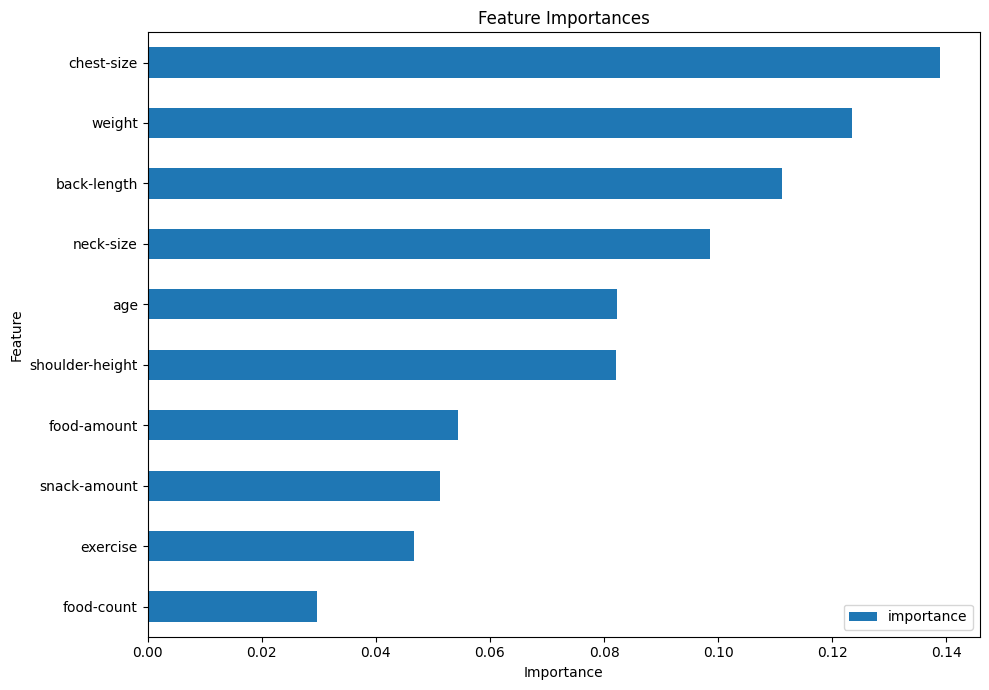

In [ ]:
# 실습 코드 : 피처 중요도 시각화

import matplotlib.pyplot as plt

fi.columns = ['importance']
fi.head(10).plot(kind='barh', figsize=(10, 7))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **나. Decision Tree**

**Step 0. 라이브러리 로딩**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

**Step 1. 모델 생성**

In [ ]:
# 실습 코드 : Decision Tree 모델 생성 (n_estimators=100, random_state=42)

model_dt = DecisionTreeClassifier(
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = None,
    max_depth = None,
    max_leaf_nodes = None
    )

**Step 2. 모델 학습**

In [ ]:
# 실습 코드 : 모델 학습

model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

**Step 3. 결과 검증**

In [ ]:
# 실습 코드 : 값 예측

pred_dt = model_dt.predict(X_test)

In [ ]:
# 실습 코드 : 성능 평가 (classificatio_report, accuracy_score)

print(classification_report(y_test, pred_dt))
print("Accuracy:", accuracy_score(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        76
           1       0.80      0.67      0.73        24
           2       0.93      0.95      0.94       500

    accuracy                           0.90       600
   macro avg       0.80      0.76      0.78       600
weighted avg       0.90      0.90      0.90       600

Accuracy: 0.8983333333333333


## **다. XG Boost**

**Step 0. 라이브러리 로딩**

In [ ]:
# XG Boost Library
import xgboost as xgb

**Step 1. 모델 생성**

In [ ]:
# 실습 코드 : XG Boost 모델 생성 (objective='multi:softprob', learning_rate=0.1, n_estimators=100)

model_xg = xgb.XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0,
    seed=42
    )

**Step 2. 모델 학습**

In [ ]:
# 실습 코드 : 모델 확습

model_xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

**Step 3. 결과 검증**

In [ ]:
# 실습 코드 : 값 예측

pred_xg = model_xg.predict(X_test)

In [ ]:
# 실습 코드 : 성능 평가 (classificatio_report, accuracy_score)

print(classification_report(y_test, pred_xg))
print("Accuracy:", accuracy_score(y_test, pred_xg))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58        76
           1       0.79      0.46      0.58        24
           2       0.90      0.98      0.94       500

    accuracy                           0.89       600
   macro avg       0.83      0.63      0.70       600
weighted avg       0.88      0.89      0.88       600

Accuracy: 0.8916666666666667


# **4. 성능 비교**

## **가. 모델별 성능 비교**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]


def acc_eval(name_, pred, actual):
    global my_predictions
    acc = (pred==actual).mean()
    my_predictions[name_] = acc

def acc_plot():
    global my_predictions
    global colors

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    min_ = 0.5   # df['acc'].min() - 0.05
    max_ = 1.05

    length = len(df)
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])

    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.01, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_, max_)
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

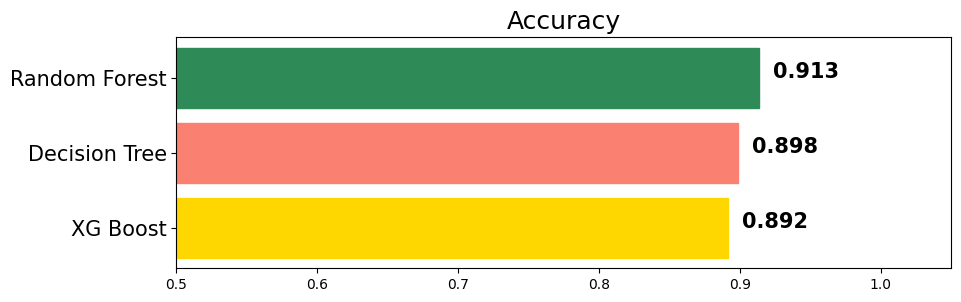

In [ ]:
# 실습 코드 : 성능 비교

acc_eval("Random Forest", pred_rf, y_test)
acc_eval("Decision Tree", pred_dt, y_test)
acc_eval("XG Boost", pred_xg, y_test)
acc_plot()

## **나. 애완견 건강상태 확인**

In [ ]:
# 데이터 프레임 만들기
X_my_pet = pd.DataFrame({
    'age': [11, 1.0],
    'weight': [3.7, 4.0],
    'shoulder-height': [23.0, 25.0],
    'neck-size': [27.0, 19.0],
    'back-length': [23.0, 30.0],
    'chest-size': [34.0, 29.0],
    'exercise': [2.0, 2.0],
    'environment': [1.0, 1.0],
    'defecation': [1.0, 1.0],
    'food-count': [4.0, 2.0],
    'food-amount': [1.25, 1.0],
    'snack-amount': [15.0, 0.0],
    'food-kind': [1.0, 1.0],
    'group_LL': [0.0, 0.0],
    'group_LS': [0.0, 0.0],
    'group_ML': [1.0, 0.0],
    'group_MS': [0.0, 0.0],
    'group_SL': [0.0, 1.0],
    'group_SS': [0.0, 0.0],
    'breed_BEA': [0.0, 0.0],
    'breed_BIC': [0.0, 1.0],
    'breed_BUL': [0.0, 0.0],
    'breed_CHL': [1.0, 0.0],
    'breed_CHS': [0.0, 0.0],
    'breed_COC': [0.0, 0.0],
    'breed_DAL': [0.0, 0.0],
    'breed_DAS': [0.0, 0.0],
    'breed_DOB': [0.0, 0.0],
    'breed_DRI': [0.0, 0.0],
    'breed_ETC': [0.0, 0.0],
    'breed_GER': [0.0, 0.0],
    'breed_GOL': [0.0, 0.0],
    'breed_GRE': [0.0, 0.0],
    'breed_HOU': [0.0, 0.0],
    'breed_HUS': [0.0, 0.0],
    'breed_JIN': [0.0, 0.0],
    'breed_LAB': [0.0, 0.0],
    'breed_MAL': [0.0, 0.0],
    'breed_MIL': [0.0, 0.0],
    'breed_MIS': [0.0, 0.0],
    'breed_MUT': [0.0, 0.0],
    'breed_POM': [0.0, 0.0],
    'breed_POO': [0.0, 0.0],
    'breed_SCH': [0.0, 0.0],
    'breed_SHE': [0.0, 0.0],
    'breed_TER': [0.0, 0.0],
    'breed_WEL': [0.0, 0.0],
    'sex_CM': [0.0, 0.0],
    'sex_IF': [0.0, 0.0],
    'sex_IM': [0.0, 1.0],
    'sex_SF': [1.0, 0.0]
})

In [ ]:
# 실습 코드 : 건강 상태 예측

pred_my_pet = model_xg.predict(X_my_pet)

In [ ]:
# 실습 코드 : 건강 상태 확인 (label_decorder.inverse_transform)

bcs_my_pet = label_encoder.inverse_transform(pred_my_pet)
print("BCS:", bcs_my_pet)

BCS: ['과체중' '정상']


# **번외편. Model 활용하기**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import tensorflow as tf

model_dnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 클래스 수에 따라 조정
])

In [ ]:
model_dnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_dnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6817 - accuracy: 0.7958 - val_loss: 0.5001 - val_accuracy: 0.8417
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.8573 - val_loss: 0.4747 - val_accuracy: 0.8375
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8583 - val_loss: 0.4565 - val_accuracy: 0.8375
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4004 - accuracy: 0.8635 - val_loss: 0.4481 - val_accuracy: 0.8458
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.3803 - accuracy: 0.8667 - val_loss: 0.4374 - val_accuracy: 0.8500
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.8714 - val_loss: 0.4301 - val_accuracy: 0.8521
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.3558 - accuracy: 0.8719 - val_loss: 0.4248 - val_accuracy: 0.8521
Epoch 8/10
60/60 [==

In [ ]:
y_pred = model_dnn.predict(X_test_scaled)
pred_dnn = y_pred.argmax(axis=-1)

print(classification_report(y_test, pred_dnn))
print("Accuracy:", accuracy_score(y_test, pred_dnn))


19/19 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.12      0.20        76
           1       0.40      0.08      0.14        24
           2       0.85      0.98      0.91       500

    accuracy                           0.83       600
   macro avg       0.60      0.39      0.41       600
weighted avg       0.79      0.83      0.79       600

Accuracy: 0.835


In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_dnn)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model_dnn.tflite', 'wb') as f:
    f.write(tflite_model)